# Transdermal Drug Delivery of Verapamil

Исследовалась модель распространения вещества при введении микроиглы под кожу.

Решался второй закон Фика с проникновением вещества в кровь:

$c = D \cdot \nabla^2 c + (K_{21}\cdot c_{b} \cdot {{V_b} \over {V_t}} - K_{12} c)$

$c_{b} = -K_e \cdot c_{b} + (K_{12}c\cdot {{V_t} \over {V_b}} - K_{21}c_{b})$

Все коэффициенты брались из статьи Transdermal drug delivery by microneedles: does skin metabolism matter?  Al-Qallaf et al.

Были промоделированы 2D и 3D случаи

# 2D случай

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from scipy.io import loadmat
import pandas as pd

In [2]:
Vb = {
    'And_2d_mm':2.63,
    'And_2d_nm':2.63,
    'Eich_2d_mm':27.39,
    'Eich_2d_nm':27.39,
    'Koike_2d_mm':6.47,
    'Koike_2d_nm':6.47
}

In [3]:
data2d = loadmat('all_2d.mat')
data3d = loadmat('A_m-m.mat')
constants = loadmat('add.mat')
C2d_time = data2d['And_2d_mm'][0][0][0]
Cb2d_time = data2d['And_2d_mm'][0][0][1]
C3d_time = data3d['And1'][0][0][0]
Cb3d_time = data3d['And1'][0][0][1]

In [85]:
data2d['And_2d_mm']

array([[(array([[[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        ...,
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00]],

       [[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 2.10058296e-02, 4.15713718e-02, ...,
         4.42340765e-02, 2.23226209e-02, 0.00000000e+00],
        [0.00000

In [4]:
D = 7*10**(-8)
dx = constants['dx'][0][0]
dy = constants['dy'][0][0]
dz = constants['dz'][0][0]

In [5]:
constants

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Sun Sep  9 10:57:19 2018',
 '__version__': '1.0',
 '__globals__': [],
 'dx': array([[0.00175]]),
 'dy': array([[0.0005]]),
 'dz': array([[0.0005]]),
 'needle_x': array([[ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]], dtype=uint8),
 'needle_y': array([[21, 22, 23, 24, 25, 26, 27, 28, 29]], dtype=uint8)}

Посчитаем концентрацию в крови

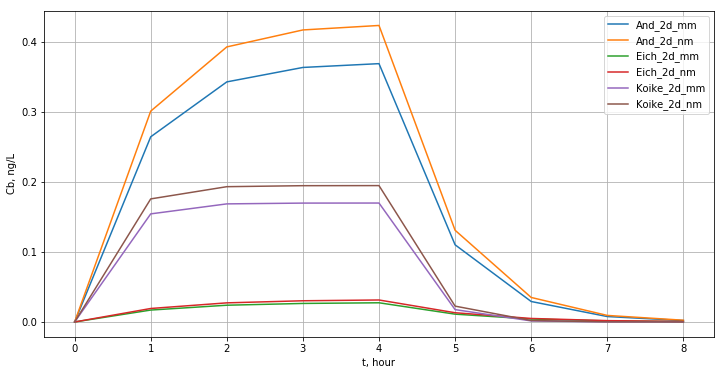

In [9]:
plt.figure(figsize=(12,6))
for key in ['And_2d_mm','And_2d_nm','Eich_2d_mm','Eich_2d_nm','Koike_2d_mm','Koike_2d_nm']:
    Cb_time = data2d[key][0][0][1]
    cb_dyn = []
    for cb in Cb_time:
        cb_dyn.append(np.sum(cb)*dx*dy*dz*9/Vb[key]/1e-5)
    plt.plot(cb_dyn, label=key)
plt.legend()
plt.grid()
plt.ylabel(r'Cb, ng/L');
plt.xlabel(r't, hour');
plt.show()

И количество поступившего вещества

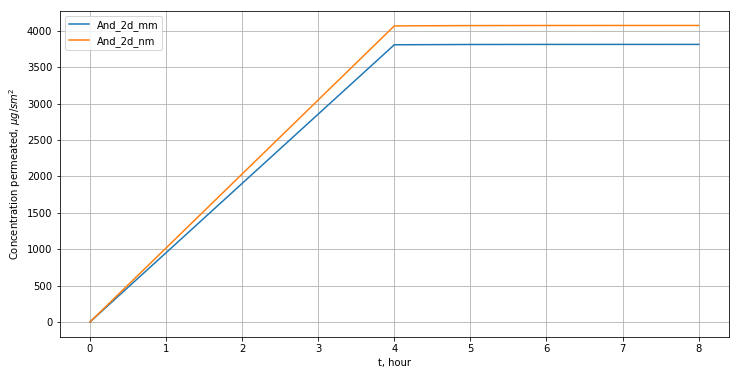

In [134]:
plt.figure(figsize=(12,6))
for key in ['And_2d_mm','And_2d_nm']:
    C_time = data2d[key][0][0][0]
    fluxes = []
    c_permeated = [0]
    c = C_time[0]
    for c in C_time[1:]:
        flux = -D*np.sum((c[14]-c[12])[20:29]*dy/dx*1000)/dy/9
        c_permeated.append(flux*3600+c_permeated[-1])
    plt.plot(c_permeated, label=key)
plt.legend()
plt.grid()
plt.ylabel(r'Concentration permeated, $\mu g/sm^2$');
plt.xlabel(r't, hour');
plt.show()

Сравним с бенчмарк

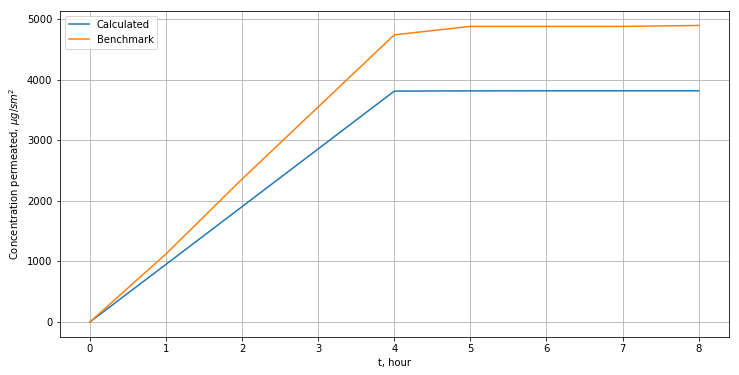

In [136]:
benchPerm = pd.read_csv('./andersen_met_perm.csv')
plt.figure(figsize=(12,6))
for key in ['And_2d_mm']:
    C_time = data2d[key][0][0][0]
    fluxes = []
    c_permeated = [0]
    c = C_time[0]
    for c in C_time[1:]:
        flux = -D*np.sum((c[14]-c[12])[20:29]/dx*1000)/9
        c_permeated.append(flux*3600+c_permeated[-1])
    plt.plot(c_permeated, label='Calculated')
plt.plot(benchPerm.time, benchPerm['concentration'], label='Benchmark')
plt.legend()
plt.grid()
plt.ylabel(r'Concentration permeated, $\mu g/sm^2$');
plt.xlabel(r't, hour');
plt.show()

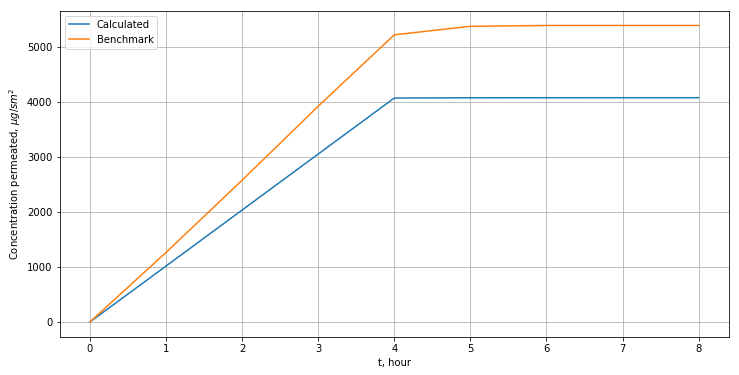

In [135]:
benchPerm = pd.read_csv('./andersen_nomet_perm.csv')
plt.figure(figsize=(12,6))
for key in ['And_2d_nm']:
    C_time = data2d[key][0][0][0]
    fluxes = []
    c_permeated = [0]
    c = C_time[0]
    for c in C_time[1:]:
        flux = -D*np.sum((c[14]-c[12])[20:29]*dy/dx*1000)/dy/9
        c_permeated.append(flux*3600+c_permeated[-1])
    plt.plot(c_permeated, label='Calculated')
plt.plot(benchPerm.time, benchPerm['concentration'], label='Benchmark')
plt.legend()
plt.grid()
plt.ylabel(r'Concentration permeated, $\mu g/sm^2$');
plt.xlabel(r't, hour');
plt.show()

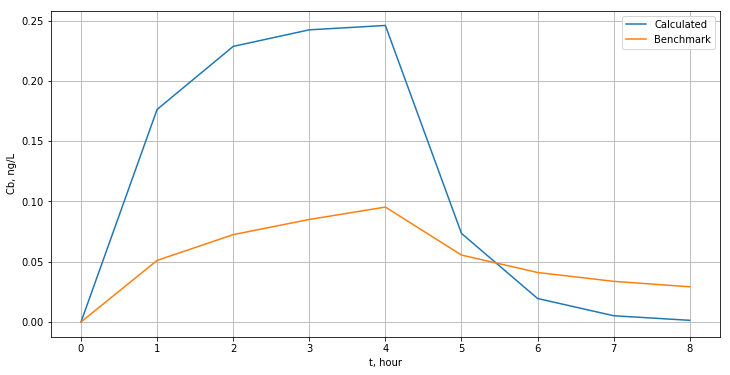

In [38]:
benchPerm = pd.read_csv('./andersen_met_blodd.csv')
plt.figure(figsize=(12,6))
for key in ['And_2d_mm']:
    Cb_time = data2d[key][0][0][1]
    cb_dyn = []
    for cb in Cb_time:
        cb_dyn.append(np.sum(cb)*dx*dy*dz*9/2*3/Vb[key]/1e-5)
    plt.plot(cb_dyn, label='Calculated')
plt.plot(benchPerm.time, benchPerm['concentration'], label='Benchmark')
plt.legend()
plt.grid()
plt.ylabel(r'Cb, ng/L');
plt.xlabel(r't, hour');
plt.show()

Картина течения в момент t=3ч

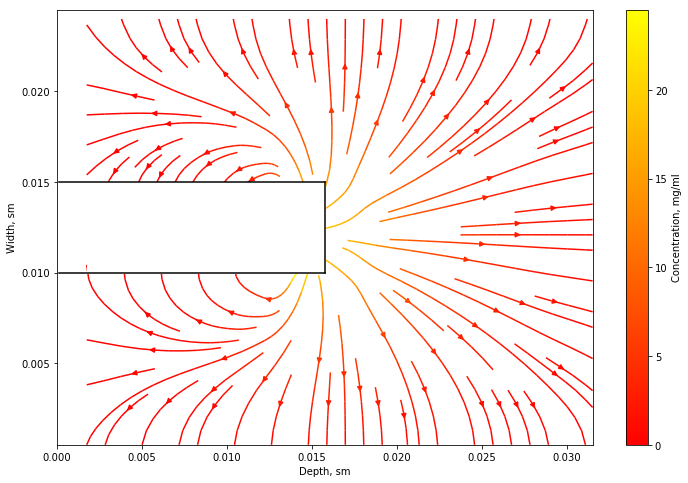

In [169]:
x = np.arange(0, 0.035,dx)
y = np.arange(0, 0.025, dy)

c_temp = data2d['And_2d_mm'][0][0][1][3]

gradX = []
for i in range(1,19):
    gradX.append(-D*(c_temp[i+1]-c_temp[i-1])/dx)
gradX = np.array(gradX)[:,1:-1]

gradY = []
for i in range(1,49):
    gradY.append(-D*(c_temp[:,i+1]-c_temp[:,i-1])/dy)
gradY = np.array(gradY).T[1:-1,:]

# gradX[0:9,:]=0
# gradY[0:9,:]=0

l = 9*0.00175
fig0, ax0 = plt.subplots()
fig0.set_size_inches(12,8)
strm = ax0.streamplot(x[1:-1], y[1:-1], gradX.T, gradY.T, color=c_temp.T[1:-1,1:-1],
                     cmap=plt.cm.autumn)
cbar = fig0.colorbar(strm.lines)
cbar.set_label('Concentration, mg/ml')
plt.fill_between([0.00175, l], [0.01,0.01], [0.015,0.015], color='white', zorder=100)
plt.plot([0.0001, l], [0.01,0.01], '-k', zorder=101)
plt.plot([0.0001, l], [0.015,0.015], '-k', zorder=101)
plt.plot([l, l], [0.01,0.015],'-k', zorder=101)
# plt.plot(np.array(tmp).T[0], np.array(tmp).T[1], 'o')
plt.xlim(0.)
plt.ylim(dy, 0.025-dy)
plt.xlabel('Depth, sm')
plt.ylabel('Width, sm')
plt.show()

Линии построены против направления градиента концентрации

На основании градиентов построим распространение вещества

In [210]:
def calc_dxdy(point: list) -> tuple:
#     try:
        i_point = int(point[0]//dx)
        i_point = min(i_point, 17)
        j_point = int(point[1]//dy)
        j_point = min(j_point, 47)
        _dx = gradX[i_point, j_point]
        _dy = gradY[i_point, j_point]
        return [point[0]+_dx, point[1]+_dy]
#     except:
#         return [0, 0.012]

In [ ]:
points = [[9*dx,(19+i)*dy] for i in range(10)]

for t in range(100):
    plt.figure(figsize=(10, 6))
    points = list(map(calc_dxdy, points))
    points += [[9*dx,(19+i)*dy] for i in range(10)]
    ps = np.array(points).T
    plt.plot(ps[0], ps[1], '.', color='red', alpha=0.5, zorder=10)
    
    l = 9*0.00175
#     cbar.set_label('Concentration, mg/ml')
    plt.fill_between([0.00175, l], [19*dy,19*dy], [28*dy,28*dy], color='white', zorder=100)
    plt.plot([0.0001, l], [19*dy,19*dy], '-k', zorder=101)
    plt.plot([0.0001, l], [28*dy,28*dy], '-k', zorder=101)
    plt.plot([l, l], [19*dy,28*dy],'-k', zorder=101)
    # plt.plot(np.array(tmp).T[0], np.array(tmp).T[1], 'o')
    plt.xlim(0., 0.035)
    plt.ylim(0, 0.025-dy)
    plt.xlabel('Depth, sm')
    plt.ylabel('Width, sm')
    plt.title('After {} sec'.format(t))
    plt.savefig('./diffusion_gif/{}.png'.format(t));
    plt.close()

In [76]:
from IPython.display import Image
Image(url='diffusion_100s.gif')

# 3D случай

Для сравнения 2D и 3D использовались коэффициенты для Andersen

In [74]:
C3d_time.shape

(79, 20, 50, 50)

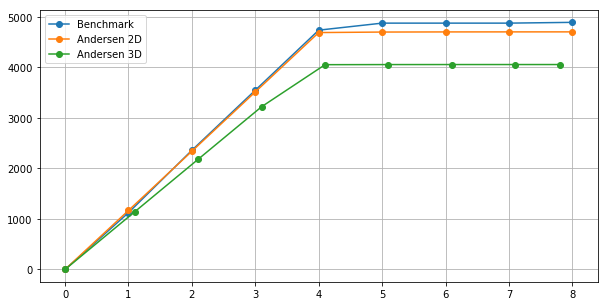

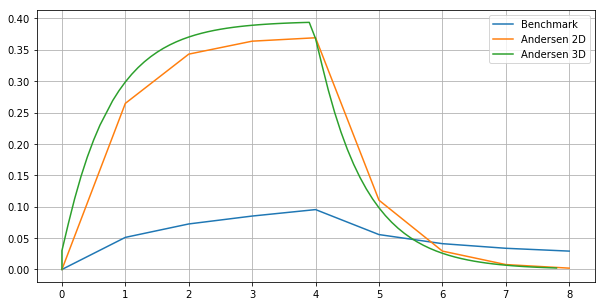

In [209]:
i_eff=5
times1  = []
fluxes1 = []
for t_idx, c in enumerate(C2d_time):
        fluxes1.append(-D*np.sum((c[11+i_eff]-c[9+i_eff])[20:29]*dy/dx*1000)/dy/4)
        times1.append(t_idx)

c_permeated1 = [0]
for i in range(1, len(times1)):
    c_permeated1.append(
        fluxes1[i]*(times1[i]-times1[i-1])*3600 + c_permeated1[-1]
    )

i_eff=1
times2  = []
fluxes2 = []
for t_idx, c in enumerate(C3d_time):
    if t_idx != 7:
        fluxes2.append(-D*np.sum((c[11+i_eff]-c[9+i_eff])[20:29,20:29]*dy/dx*1000)/dy/81)
        times2.append(t_idx*0.1)

c_permeated2 = [0]
for i in range(1, len(times2)):
    c_permeated2.append(
        fluxes2[i]*(times2[i]-times2[i-1])*3600 + c_permeated2[-1]
    )

benchPerm = pd.read_csv('./andersen_met_perm.csv')

plt.figure(figsize=(10,5))
plt.plot(benchPerm.time, benchPerm['concentration'], 'o-', label='Benchmark')
plt.plot(times1,c_permeated1, 'o-', label='Andersen 2D')
plt.plot(times2[::10]+[times2[-1]],c_permeated2[::10]+[c_permeated2[-1]], 'o-', label='Andersen 3D')
plt.legend()
plt.grid()
plt.show()

cb_din1 = [0]
ts1 = [0]
for t_idx, cb in enumerate(Cb2d_time):
        cb_din1.append(
            np.sum(cb)*dx*dy*dz*9/1e-5/Vb['And_2d_mm']
        )
        ts1.append(t_idx)

cb_din2 = [0]
ts2 = [0]
for t_idx, cb in enumerate(Cb3d_time):
    if t_idx != 7:
        cb_din2.append(
            np.sum(cb)*dx*dy*dz/1e-5/Vb['And_2d_mm']
        )
        ts2.append(t_idx*0.1)

benchPerm = pd.read_csv('./andersen_met_blodd.csv')
plt.figure(figsize=(10,5))
plt.plot(benchPerm.time, benchPerm['concentration'], label='Benchmark')
plt.plot(ts1, cb_din1, label='Andersen 2D')
plt.plot(ts2, cb_din2, label='Andersen 3D')
plt.legend()
plt.grid()
plt.show()